In [ ]:
!pip install pyarrow

In [1]:
import pandas as pd

# Charger les fichiers Parquet (en adaptant les chemins si besoin)
freq = pd.read_parquet("data/raw/freMTPLfreq.parquet")
sev = pd.read_parquet("data/raw/freMTPLsev.parquet")

# Afficher les premières lignes
display(freq.head())
display(sev.head())

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905
2,314463,1150
3,318713,1220
4,309380,55077


# Analyse exploratoire

## Description des bases de données

In [8]:
freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413169 entries, 0 to 413168
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   PolicyID   413169 non-null  category
 1   ClaimNb    413169 non-null  int32   
 2   Exposure   413169 non-null  float64 
 3   Power      413169 non-null  category
 4   CarAge     413169 non-null  int32   
 5   DriverAge  413169 non-null  int32   
 6   Brand      413169 non-null  category
 7   Gas        413169 non-null  category
 8   Region     413169 non-null  category
 9   Density    413169 non-null  int32   
dtypes: category(5), float64(1), int32(4)
memory usage: 31.9 MB


### freMTPLfreq — Description des variables

-PolicyID : Identifiant du contrat (utilisé pour faire le lien avec le jeu de données des sinistres).

-ClaimNb : Nombre de sinistres durant la période d’exposition.

-Exposure : Durée d’exposition du contrat, en années.

-Power : Puissance du véhicule (variable catégorielle ordonnée).

-CarAge : Âge du véhicule, en années.

-DriverAge : Âge du conducteur, en années (en France, l’âge minimum pour conduire est 18 ans).

-Brand : Marque du véhicule, regroupée en catégories :

    -A : Renault, Nissan, Citroën

    -B : Volkswagen, Audi, Skoda, Seat

    -C : Opel, General Motors, Ford

    -D : Fiat

    -E : Mercedes, Chrysler, BMW

    -F : Japonaises (sauf Nissan) et Coréennes

    -G : Autres

-Gas : Type de carburant (Diesel ou essence).

-Region : Région du contrat en France (classification 1970–2015).

-Density : Densité d’habitants (nombre d’habitants par km²) dans la commune de résidence du conducteur.

In [3]:
sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16181 entries, 0 to 16180
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PolicyID     16181 non-null  int32
 1   ClaimAmount  16181 non-null  int32
dtypes: int32(2)
memory usage: 126.5 KB


### freMTPLsev — Description des variables

-PolicyID : La date d’occurrence (utilisée pour faire le lien avec le jeu de données des contrats).

-ClaimAmount : Le coût du sinistre, observé à une date récente.

## Analyse univariée
L’analyse univariée consiste à étudier chaque variable individuellement afin de comprendre sa distribution et ses caractéristiques principales. Pour les variables quantitatives (ClaimNb, Exposure, CarAge, DriverAge, Density), on examine des statistiques comme la moyenne, l’écart-type, les valeurs minimales et maximales, ainsi que les quartiles. Des visualisations telles que les histogrammes ou les boxplots permettent d’identifier la forme de la distribution, la présence d’asymétries ou de valeurs extrêmes. Pour les variables catégorielles (Power, Brand, Gas, Region), on analyse la fréquence et la proportion de chaque modalité, souvent représentées par des diagrammes en barres ou en camembert. Cette étape permet de se familiariser avec le jeu de données, de détecter des anomalies éventuelles et de préparer l’étape suivante d’analyse multivariée.
### Analyse des variables numériques

In [17]:
## Vérification des valeurs manquantes
missing_values_freq=freq.isnull().sum()
print("Missing values freq:")
print(missing_values_freq)

Missing values freq:
PolicyID     0
ClaimNb      0
Exposure     0
Power        0
CarAge       0
DriverAge    0
Brand        0
Gas          0
Region       0
Density      0
dtype: int64


In [18]:
## Vérification des valeurs manquantes
missing_values_sev=sev.isnull().sum()
print("Missing values freq:")
print(missing_values_sev)

Missing values freq:
PolicyID       0
ClaimAmount    0
dtype: int64


In [10]:
freq.describe()

,ClaimNb,Exposure,CarAge,DriverAge,Density
count,413169.000000,413169.000000,413169.000000,413169.000000,413169.000000
mean,0.039163,0.561088,7.532404,45.319876,1985.153913
std,0.204053,0.369477,5.763011,14.328120,4776.254543
min,0.000000,0.002732,0.000000,18.000000,2.000000
25%,0.000000,0.200000,3.000000,34.000000,67.000000
50%,0.000000,0.540000,7.000000,44.000000,287.000000
75%,0.000000,1.000000,12.000000,54.000000,1410.000000
max,4.000000,1.990000,100.000000,99.000000,27000.000000


### ClaimNb(nombre de sinistres)

L'analyse révèle que le nombre maximum de sinistres est de 4. Tandis que la moyenne est de **0.039**, ce qui suggère que la grande majorité des clients n’ont pas eu de sinistre mais que quelques-uns ont plusieurs déclarations. De plus les quartiles à 0 confirment que plus de 75 % des assurés n’ont pas eu un seul sinistre sur la période observée.

### Exposure(durée d'exposition en années)

La moyenne est à **0.56** soit environ 6-7 mois d'exposition en moyenne. Tandis que la médiane à 
**0.54**.Donc nous avons majoritairement des contrats couvrant un peu plus de la moitié de l’année.


### CarAge(âge du véhicule)

L'âge moyen d'un véhicule est de **7.53**. Les quartiles montrent que 75% des véhicules ont un âge inférieur ou égal à 12 ans. Les véhicules les plus âgées ont 100 ans.

### DriverAge (âge du conducteur)

L'âge moyen d'un conducteur est de **45.3** ans. L'âge minimum est de 18 ans ce qui correspond à l'âge légal. et l'âge maximum est de 18 ans. 

### Density(densité de population dans la commune de résidence du conducteur) revoir

Valeur médiane (287) très inférieure à la moyenne (1985), max extrême (27000), ce qui révèle de très fortes disparités régionales (la majorité vivent dans des zones peu denses, quelques cas urbains très concentrés).


       PolicyID        ClaimNb       Exposure   Power         CarAge  \
count    413169  413169.000000  413169.000000  413169  413169.000000   
unique   413169            NaN            NaN      12            NaN   
top           1            NaN            NaN       f            NaN   
freq          1            NaN            NaN   95718            NaN   
mean        NaN       0.039163       0.561088     NaN       7.532404   
std         NaN       0.204053       0.369477     NaN       5.763011   
min         NaN       0.000000       0.002732     NaN       0.000000   
25%         NaN       0.000000       0.200000     NaN       3.000000   
50%         NaN       0.000000       0.540000     NaN       7.000000   
75%         NaN       0.000000       1.000000     NaN      12.000000   
max         NaN       4.000000       1.990000     NaN     100.000000   

            DriverAge                       Brand      Gas  Region  \
count   413169.000000                      413169   413169  41316

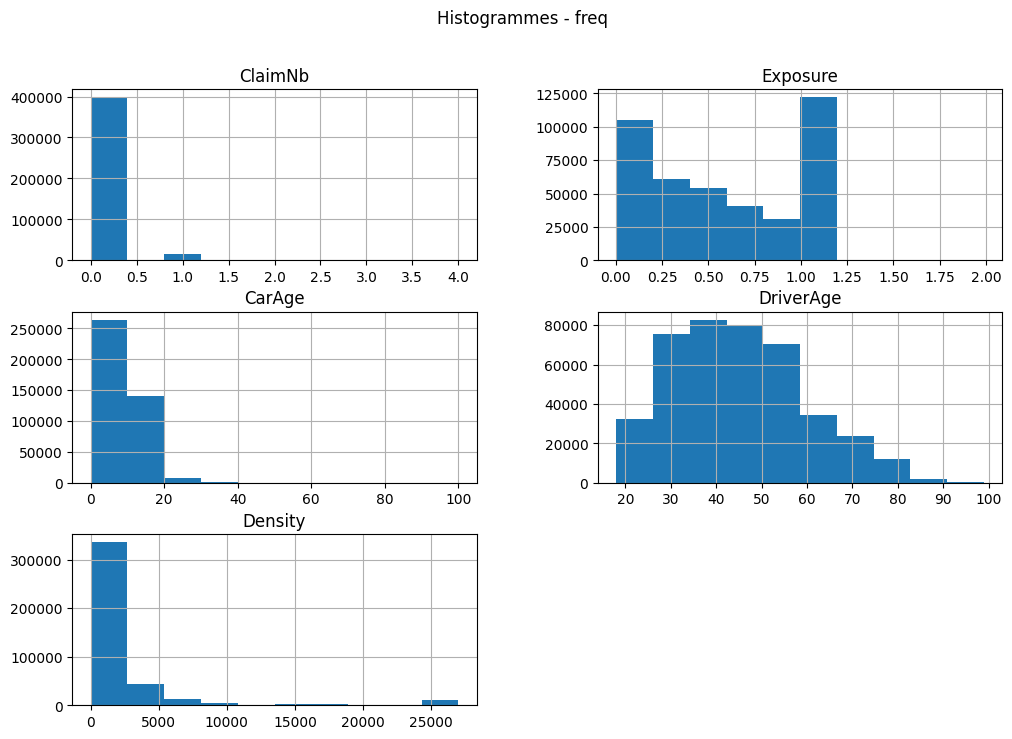

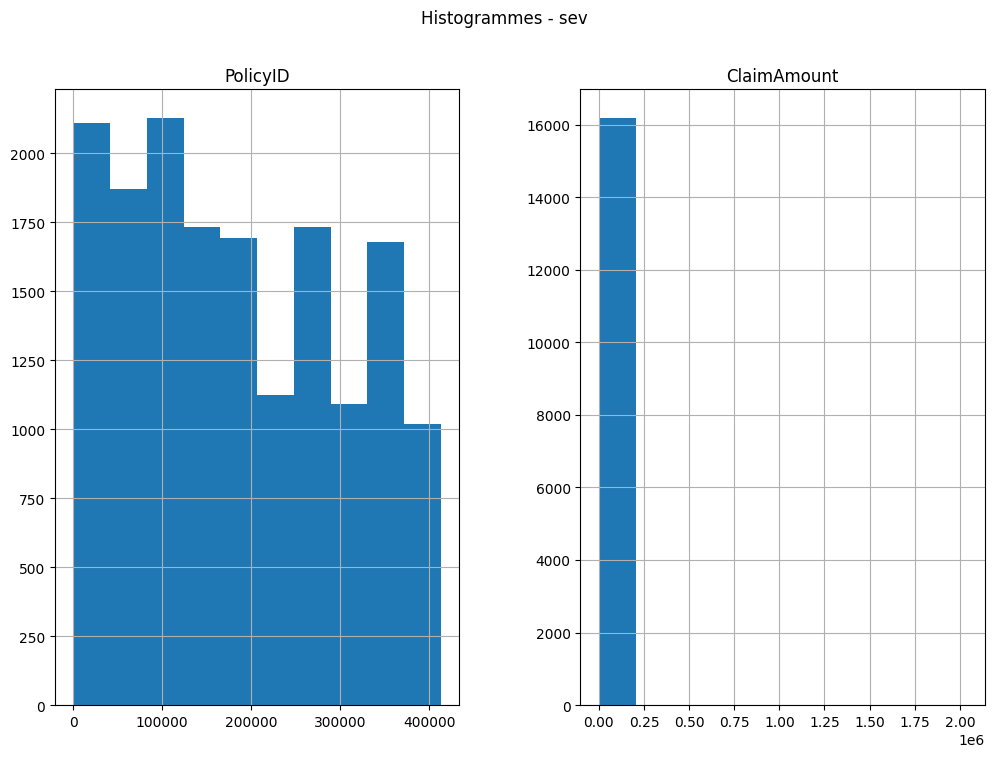

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les fichiers parquet
freq = pd.read_parquet("data/raw/freMTPLfreq.parquet")
sev = pd.read_parquet("data/raw/freMTPLsev.parquet")

# Statistiques descriptives
print(freq.describe(include='all'))
print(sev.describe(include='all'))

# Histogrammes des variables numériques
num_cols_freq = freq.select_dtypes(include='number').columns
num_cols_sev = sev.select_dtypes(include='number').columns

freq[num_cols_freq].hist(figsize=(12,8))
plt.suptitle("Histogrammes - freq")
plt.show()

sev[num_cols_sev].hist(figsize=(12,8))
plt.suptitle("Histogrammes - sev")
plt.show()

In [ ]:
for col in freq.select_dtypes('number').columns:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(freq[col], kde=True)
    plt.title(f"Distribution - freq[{col}]")
    plt.subplot(1,2,2)
    sns.boxplot(x=freq[col])
    plt.show()

for col in sev.select_dtypes('number').columns:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(sev[col], kde=True)
    plt.title(f"Distribution - sev[{col}]")
    plt.subplot(1,2,2)
    sns.boxplot(x=sev[col])
    plt.show()

In [ ]:
import scipy.stats as stats

# ================================
#  EDA SÉVÉRITÉ : ClaimAmount
# ================================

# 1. Statistiques descriptives de base
print("Statistiques descriptives de ClaimAmount :")
print(sev["ClaimAmount"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
print()

# Skewness / Kurtosis
print("Skewness :", sev["ClaimAmount"].skew())
print("Kurtosis :", sev["ClaimAmount"].kurt())
print()

# 2. Histogramme (échelle linéaire)
plt.figure(figsize=(8,5))
sns.histplot(sev["ClaimAmount"], bins=60, kde=True)
plt.title("Histogramme de ClaimAmount (scale linéaire)")
plt.xlabel("ClaimAmount")
plt.ylabel("Effectif")
plt.show()

# 3. Histogramme log-scale
plt.figure(figsize=(8,5))
sns.histplot(sev["ClaimAmount"], bins=60, kde=True, log_scale=True)
plt.title("Histogramme de ClaimAmount (échelle logarithmique)")
plt.xlabel("ClaimAmount")
plt.ylabel("Effectif (log-scale)")
plt.show()

# 4. Distribution de log(ClaimAmount)
log_claim = np.log(sev["ClaimAmount"])

plt.figure(figsize=(8,5))
sns.histplot(log_claim, bins=60, kde=True)
plt.title("Distribution de log(ClaimAmount)")
plt.xlabel("log(ClaimAmount)")
plt.ylabel("Effectif")
plt.show()

# 5. QQ-plot pour vérifier la normalité de log(Y)
plt.figure(figsize=(6,6))
stats.probplot(log_claim, dist="norm", plot=plt)
plt.title("QQ-plot de log(ClaimAmount) vs Normal")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés")
plt.show()

# 6. Ajustement d'une loi Lognormale sur ClaimAmount
shape, loc, scale = stats.lognorm.fit(sev["ClaimAmount"], floc=0)
print("Paramètres Lognormale :")
print("  shape (sigma) =", shape)
print("  loc           =", loc)
print("  scale         =", scale)
print()

plt.figure(figsize=(6,6))
stats.probplot(
    sev["ClaimAmount"],
    dist=stats.lognorm(shape, loc=loc, scale=scale),
    plot=plt
)
plt.title("QQ-plot de ClaimAmount vs Lognormale ajustée")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés")
plt.show()

# 7. Ajustement d'une loi Gamma sur ClaimAmount
alpha, loc_g, beta = stats.gamma.fit(sev["ClaimAmount"], floc=0)
print("Paramètres Gamma :")
print("  alpha (shape) =", alpha)
print("  loc           =", loc_g)
print("  beta (scale)  =", beta)
print()

plt.figure(figsize=(6,6))
stats.probplot(
    sev["ClaimAmount"],
    dist=stats.gamma(alpha, loc=loc_g, scale=beta),
    plot=plt
)
plt.title("QQ-plot de ClaimAmount vs Gamma ajustée")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés")
plt.show()

# 8. Analyse des valeurs extrêmes (boxplots)
plt.figure(figsize=(8,5))
sns.boxplot(x=sev["ClaimAmount"])
plt.title("Boxplot de ClaimAmount")
plt.xlabel("ClaimAmount")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=log_claim)
plt.title("Boxplot de log(ClaimAmount)")
plt.xlabel("log(ClaimAmount)")
plt.show()

In [13]:
cat_cols = freq.select_dtypes('object').columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    freq[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Répartition de {col}")
    plt.ylabel("Fréquence (%)")
    plt.show()

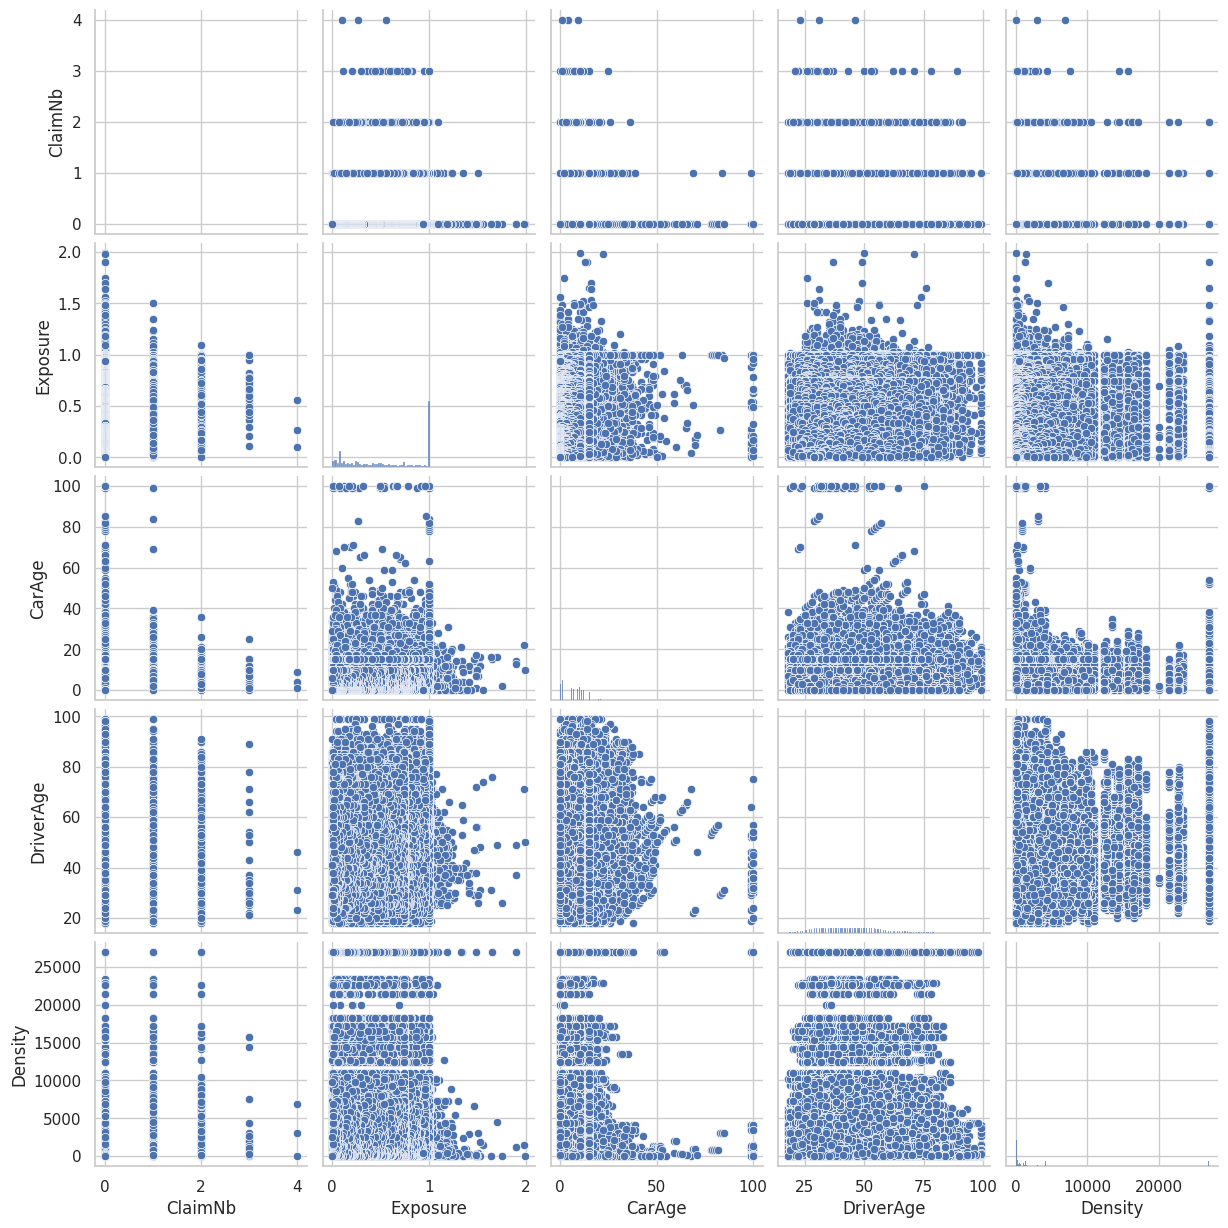

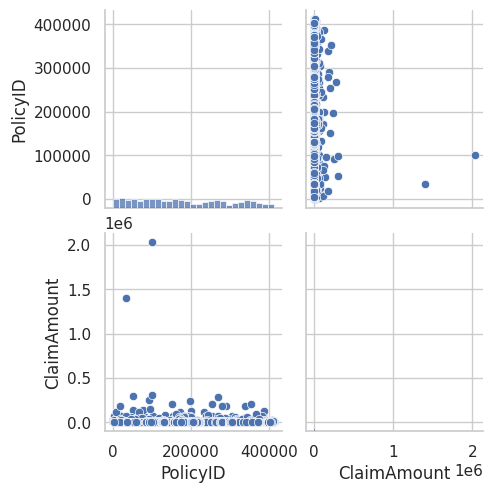

In [14]:
sns.pairplot(freq.select_dtypes('number'))
plt.show()

sns.pairplot(sev.select_dtypes('number'))
plt.show()

## Analyse des variables catégorielles


=== Variable : Power ===
       Count  Percentage
Power                   
f      95718   23.166791
g      91198   22.072808
e      77022   18.641766
d      68014   16.461545
h      26698    6.461763
j      18038    4.365768
i      17616    4.263631
k       9537    2.308256
l       4681    1.132950
m       1832    0.443402
o       1508    0.364984
n       1307    0.316335

=== Variable : Brand ===
                                     Count  Percentage
Brand                                                 
Renault, Nissan or Citroen          218200   52.811319
Japanese (except Nissan) or Korean   79060   19.135027
Opel, General Motors or Ford         37402    9.052470
Volkswagen, Audi, Skoda or Seat      32638    7.899431
Mercedes, Chrysler or BMW            19280    4.666371
Fiat                                 16723    4.047496
other                                 9866    2.387885

=== Variable : Gas ===
          Count  Percentage
Gas                        
Regular  207224   50.15

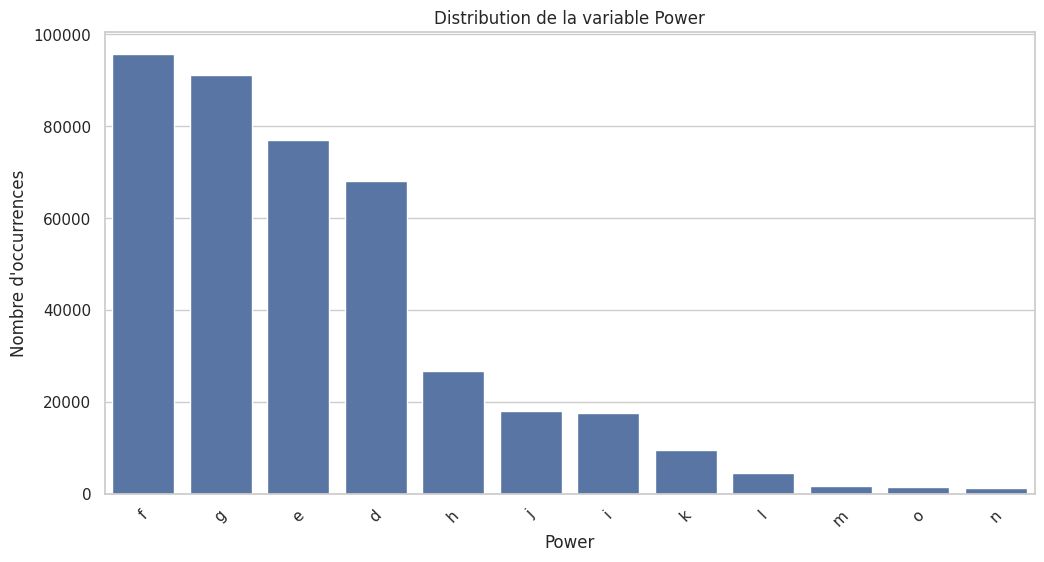

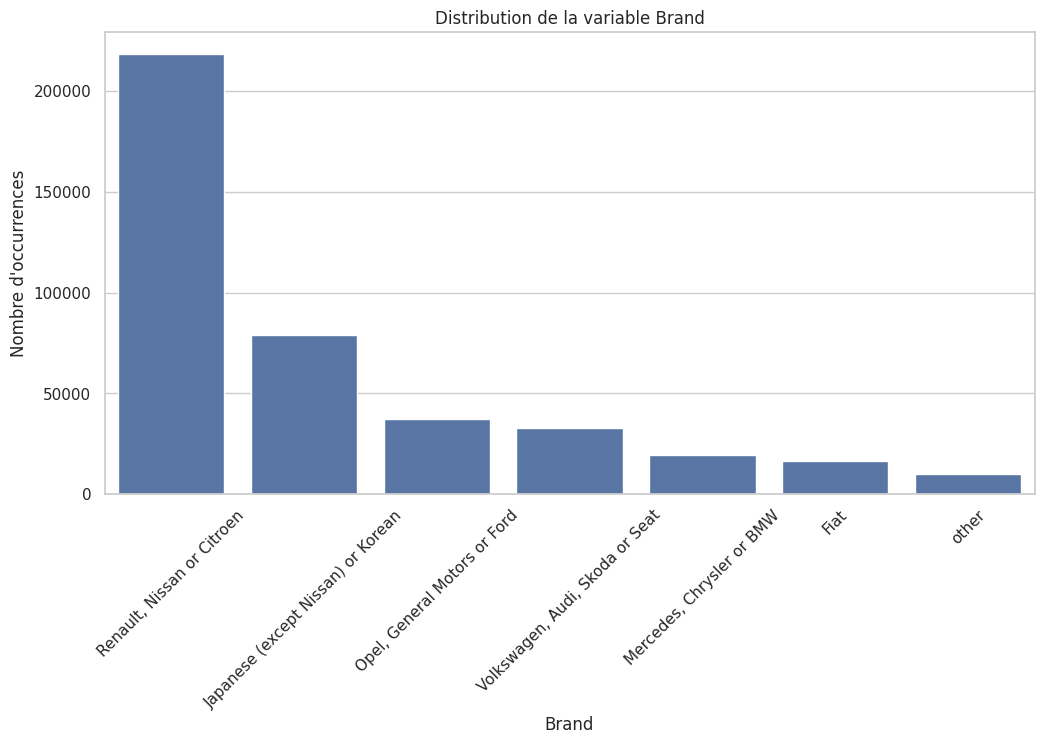

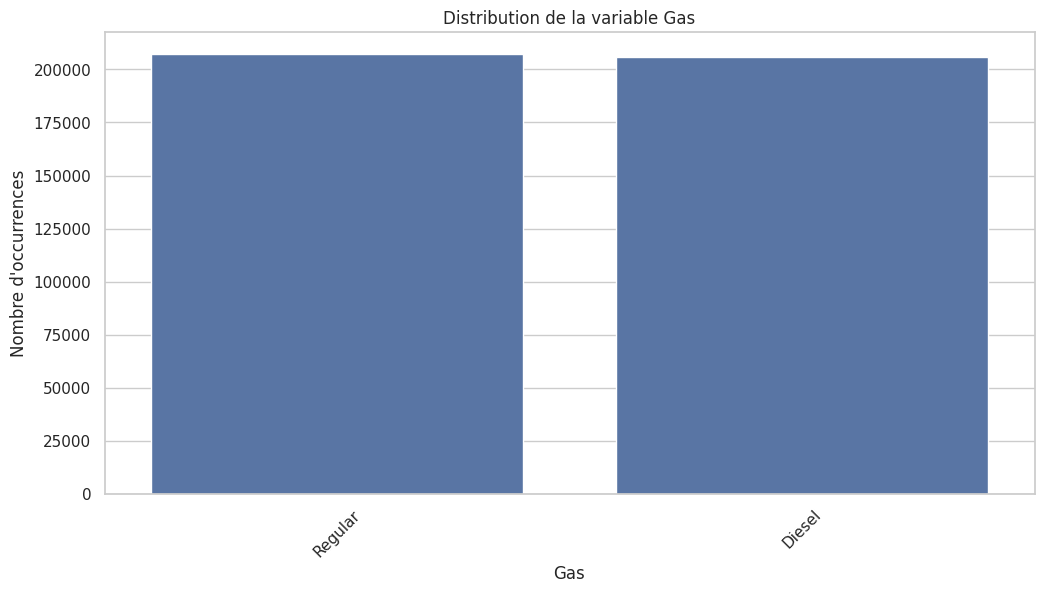

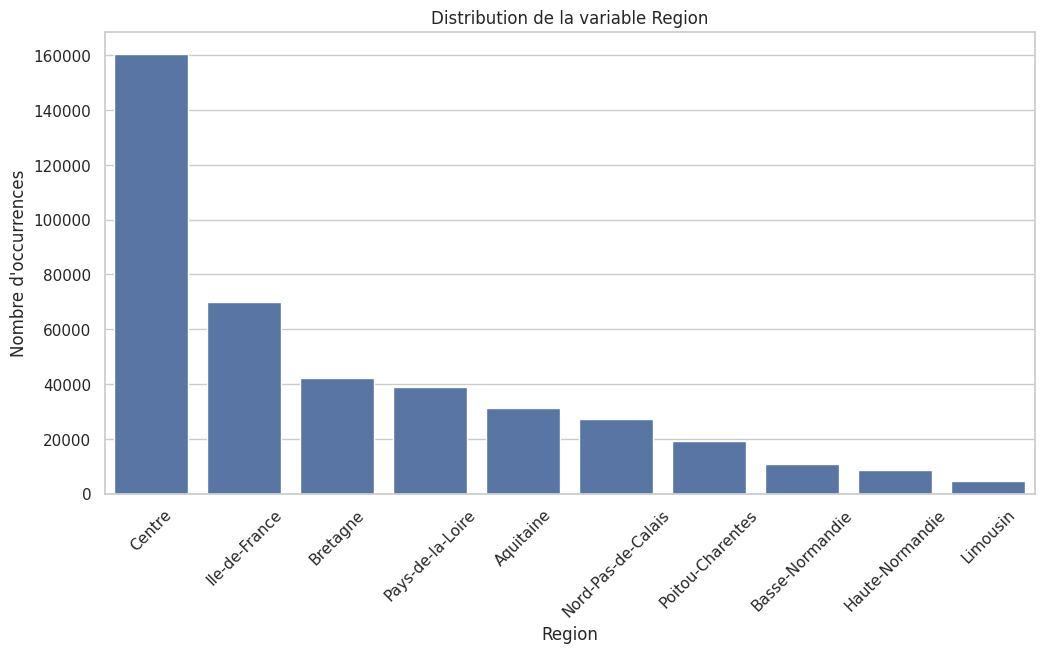

In [5]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Supposons que ton dataframe s'appelle freMTPLfreq
# freMTPLfreq = pd.read_csv("freMTPLfreq.csv")  # si besoin

# -------------------------------
# 1. Statistiques descriptives
# -------------------------------
cat_columns = ['Power', 'Brand', 'Gas', 'Region']

# Compter les occurrences et les pourcentages
for col in cat_columns:
    print(f"\n=== Variable : {col} ===")
    counts = freq[col].value_counts()
    percents = freq[col].value_counts(normalize=True) * 100
    stats = pd.concat([counts, percents], axis=1)
    stats.columns = ['Count', 'Percentage']
    print(stats)

# -------------------------------
# 2. Visualisation des distributions
# -------------------------------
for col in cat_columns:
    plt.figure()
    sns.countplot(data=freq, x=col, order=freq[col].value_counts().index)
    plt.title(f"Distribution de la variable {col}")
    plt.xticks(rotation=45)
    plt.ylabel("Nombre d'occurrences")
    plt.show()



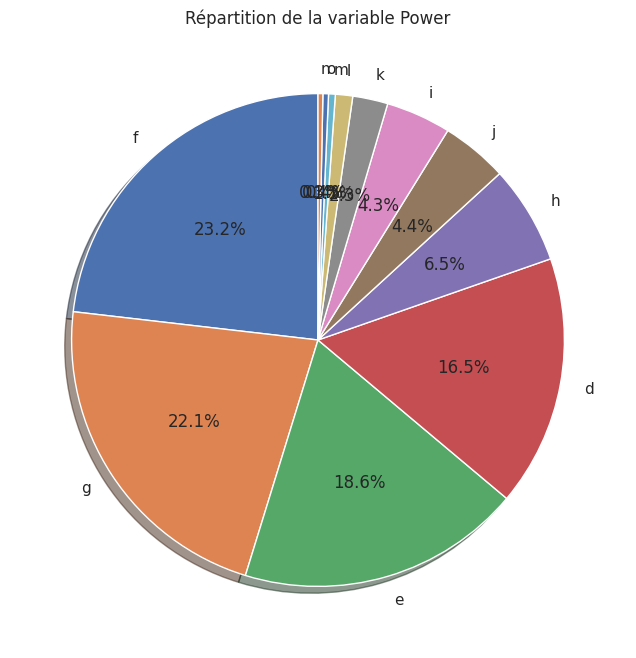

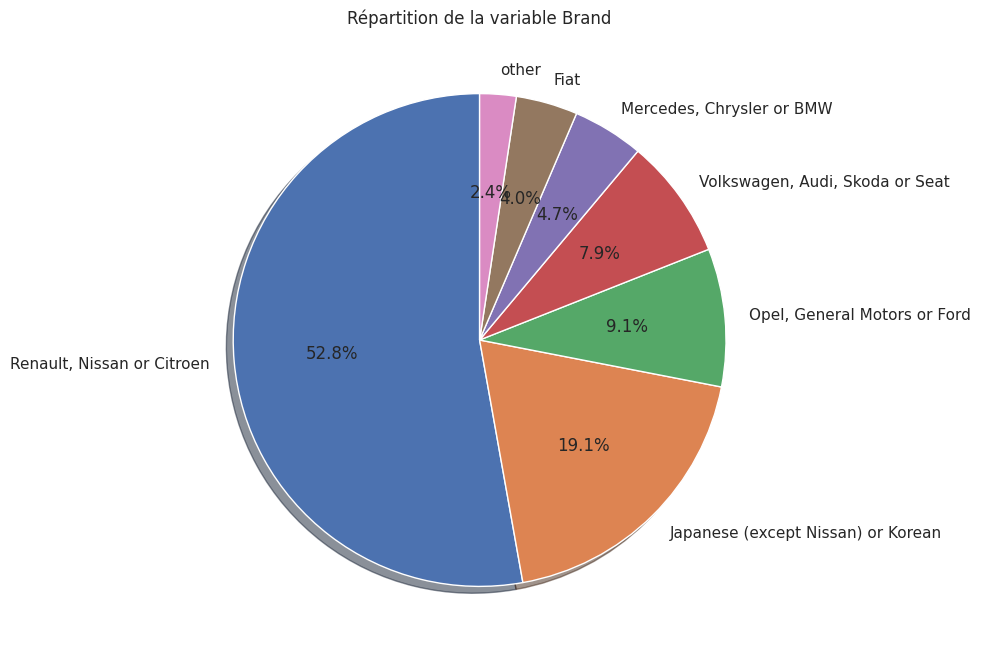

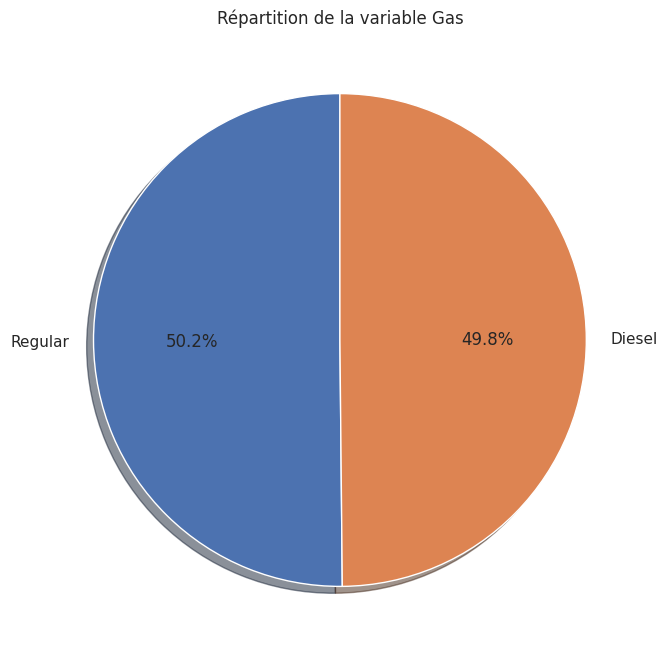

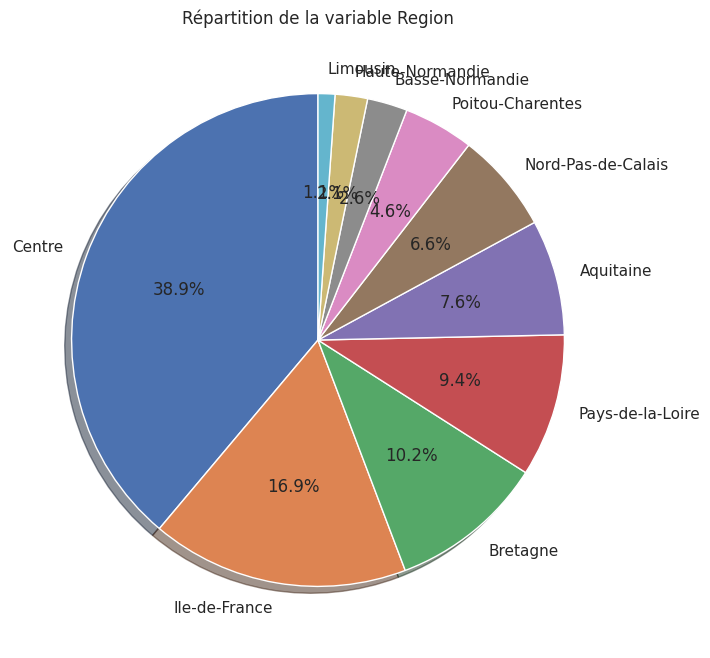

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que ton dataframe s'appelle freMTPLfreq
# freMTPLfreq = pd.read_csv("freMTPLfreq.csv")  # si besoin

# Liste des variables catégorielles
cat_columns = ['Power', 'Brand', 'Gas', 'Region']

# Boucle pour créer un camembert pour chaque variable
for col in cat_columns:
    plt.figure(figsize=(8,8))
    freq[col].value_counts().plot.pie(
        autopct='%1.1f%%',        # pourcentage
        startangle=90,            # rotation
        shadow=True               # ombre
    )
    plt.title(f"Répartition de la variable {col}")
    plt.ylabel("")               # enlève le label de l'axe y
    plt.show()


## Analyse multivariée

/tmp/ipykernel_47183/1529233575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_croisee = freq.groupby('DriverAgeGroup')['ClaimNb'].sum().reset_index()


Tableau croisé : Nombre total de sinistres par tranche d'âge
  DriverAgeGroup  Total_ClaimNb
0          18-24           1343
1          25-34           3128
2          35-44           3701
3          45-54           4153
4          55-64           2071
5          65-74           1139
6          75-84            572
7          85-94             69
8            95+              5


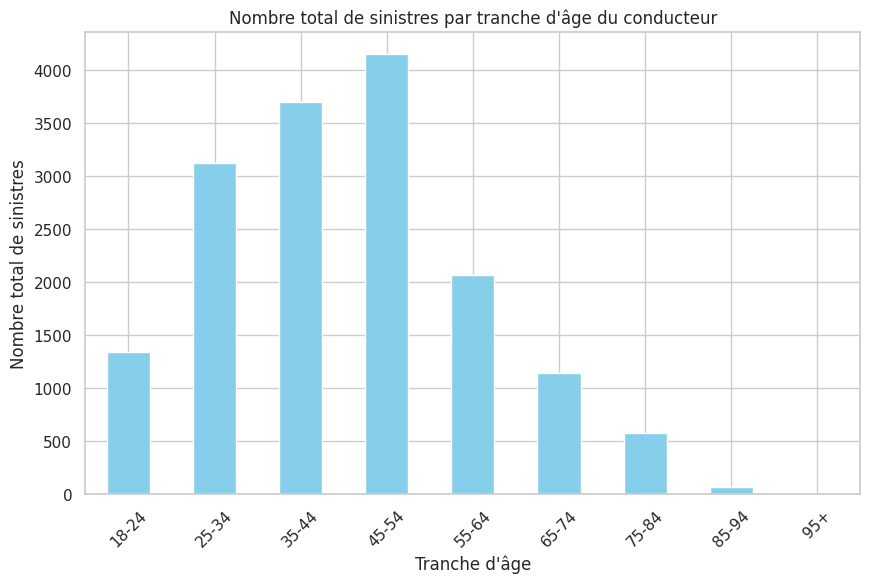

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que ton dataframe s'appelle freMTPLfreq
# freMTPLfreq = pd.read_csv("freMTPLfreq.csv")  # si besoin

# -----------------------
# 1. Créer des tranches d'âge
# -----------------------
bins = [18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75-84','85-94','95+']

freq['DriverAgeGroup'] = pd.cut(freq['DriverAge'], bins=bins, labels=labels, right=False)

# -----------------------
# 2. Tableau croisé
# -----------------------
# Somme du nombre de sinistres par tranche d'âge
table_croisee = freq.groupby('DriverAgeGroup')['ClaimNb'].sum().reset_index()
table_croisee.rename(columns={'ClaimNb':'Total_ClaimNb'}, inplace=True)

print("Tableau croisé : Nombre total de sinistres par tranche d'âge")
print(table_croisee)

# -----------------------
# 3. Histogramme avec Pandas
# -----------------------
table_croisee.plot(kind='bar', x='DriverAgeGroup', y='Total_ClaimNb', 
                   legend=False, color='skyblue', figsize=(10,6))
plt.title("Nombre total de sinistres par tranche d'âge du conducteur")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre total de sinistres")
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_47183/2603777558.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_region = freq.groupby('Region')['ClaimNb'].sum().reset_index()


Tableau croisé : Nombre total de sinistres par région
               Region  Total_ClaimNb
0           Aquitaine           1055
1     Basse-Normandie            452
2            Bretagne           1871
3              Centre           6475
4     Haute-Normandie            220
5       Ile-de-France           2591
6            Limousin            197
7  Nord-Pas-de-Calais            944
8    Pays-de-la-Loire           1576
9    Poitou-Charentes            800


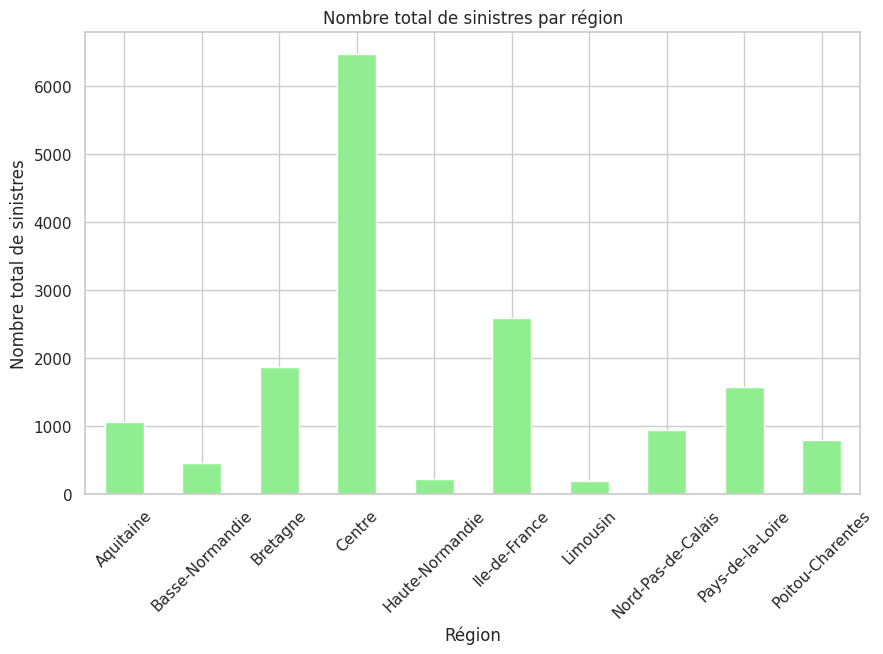

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que ton dataframe s'appelle freMTPLfreq

# -----------------------
# 1. Tableau croisé : somme des sinistres par région
# -----------------------
table_region = freq.groupby('Region')['ClaimNb'].sum().reset_index()
table_region.rename(columns={'ClaimNb':'Total_ClaimNb'}, inplace=True)

print("Tableau croisé : Nombre total de sinistres par région")
print(table_region)

# -----------------------
# 2. Histogramme
# -----------------------
table_region.plot(kind='bar', x='Region', y='Total_ClaimNb', 
                  legend=False, color='lightgreen', figsize=(10,6))
plt.title("Nombre total de sinistres par région")
plt.xlabel("Région")
plt.ylabel("Nombre total de sinistres")
plt.xticks(rotation=45)
plt.show()


In [ ]:

import seaborn as sns

# Charger vos fichiers parquet
freq = pd.read_parquet("data/raw/freMTPLfreq.parquet")
sev = pd.read_parquet("data/raw/freMTPLsev.parquet")

# --- Préparation : ne garder que les colonnes numériques ---
freq_num = freq.select_dtypes(include='number')
sev_num = sev.select_dtypes(include='number')

# --- Matrice de corrélation ---
corr_freq = freq_num.corr()
corr_sev = sev_num.corr()

# --- Heatmap freq ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_freq, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation - freq")
plt.show()

# --- Heatmap sev ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sev, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation - sev")
plt.show()

In [15]:
print("Fréquence - dimensions :", freq.shape)
print("Sévérité - dimensions :", sev.shape)

print(freq.dtypes)
print(sev.dtypes)

print("Valeurs manquantes freq:\n", freq.isna().mean()*100)
print("Valeurs manquantes sev:\n", sev.isna().mean()*100)

# Outliers via IQR
def detect_outliers(df, columns):
    out = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        out[col] = ((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)).mean()
    return out

print("Outliers freq:", detect_outliers(freq, freq.select_dtypes('number').columns))
print("Outliers sev:", detect_outliers(sev, sev.select_dtypes('number').columns))

Fréquence - dimensions : (413169, 10)
Sévérité - dimensions : (16181, 2)
PolicyID     category
ClaimNb         int32
Exposure      float64
Power        category
CarAge          int32
DriverAge       int32
Brand        category
Gas          category
Region       category
Density         int32
dtype: object
PolicyID       int32
ClaimAmount    int32
dtype: object
Valeurs manquantes freq:
 PolicyID     0.0
ClaimNb      0.0
Exposure     0.0
Power        0.0
CarAge       0.0
DriverAge    0.0
Brand        0.0
Gas          0.0
Region       0.0
Density      0.0
dtype: float64
Valeurs manquantes sev:
 PolicyID       0.0
ClaimAmount    0.0
dtype: float64
Outliers freq: {'ClaimNb': np.float64(0.0372486803220958), 'Exposure': np.float64(0.0), 'CarAge': np.float64(0.004571979020691291), 'DriverAge': np.float64(0.003487676955434701), 'Density': np.float64(0.15433636115003788)}
Outliers sev: {'PolicyID': np.float64(0.0), 'ClaimAmount': np.float64(0.13101786045361843)}
